In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from skimage import io
from skimage.transform import resize
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

random_state = 42
gen = random.Random(random_state)

data_dir = 'data/flowers/'
load_in_memory = False

files = []
for sub_folder in os.listdir(data_dir):
    files.extend([sub_folder + '/' + file for file in os.listdir(data_dir + sub_folder)])
gen.shuffle(files)
# device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [43]:
class FlowerDataset(Dataset):
    def __init__(self, files, data_dir, in_memory = False):
        gen.shuffle(files)
        self.in_memory = in_memory
        self.files = files
        self.idx2lbl = list(set(file.split('/')[0] for file in files))
        self.lbl2idx = {label: i for i, label in enumerate(self.idx2lbl)}
        self.data = []
        
        if in_memory:
            for file in tqdm(files):
                self.data.append(self._read_file(file))
    
    def _read_file(self, file):
        image = io.imread(data_dir + '/' + file)
        #image = resize(image, (image.shape[0], max_w), anti_aliasing=False)
        label = file.split('/')[0]
        image = (image - image.min())/(image.max() - image.min()) # Normalization
        return (image, self.lbl2idx[label])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.in_memory:
            return self.data[idx]
        else:
            return self._read_file(files[idx])
        

l = len(files)
train_size = 0.9
cutoff = int(l*train_size)

train_set = FlowerDataset(files[:cutoff], data_dir, in_memory=load_in_memory)
test_set = FlowerDataset(files[cutoff:], data_dir, in_memory=load_in_memory)

In [5]:
# To have a look at the image sizes
# Only run this if you have to, because it takes a few minutes

# all_sizes = [im.shape for im, _ in train_set] + [im.shape for im, _ in test_set]
# plt.hist([x[0] for x in all_sizes])
# plt.title('Height')
# plt.show()
# plt.hist([x[1] for x in all_sizes])
# plt.title('Width')
# plt.show()

Text(0.5, 1.0, 'sunflower_4')

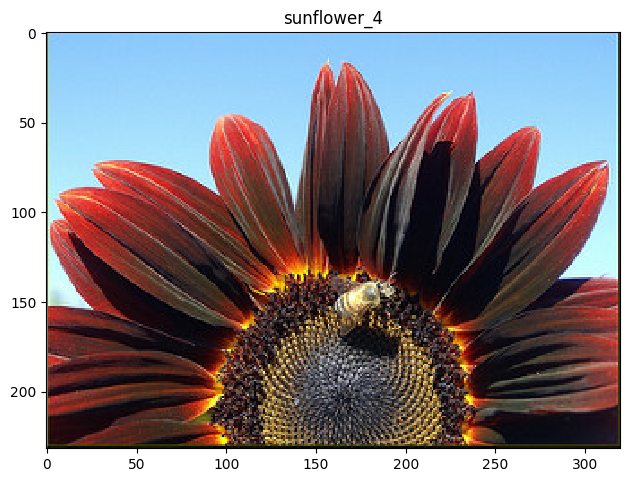

In [44]:
# Display example image
im, label = train_set[0]
io.imshow(im)
plt.title(train_set.idx2lbl[label] + '_' + str(label))

In [51]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.1),
                                        nn.BatchNorm2d(16),
                                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.15),
                                        nn.BatchNorm2d(32),
                                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm2d(64))
        
                                        
        self.linear_layer1 = nn.Linear(64, 16)
        self.dropout1 = nn.Dropout(0.5)
        self.activ1 = nn.ReLU()
        self.linear_layer2 = nn.Linear(16, num_classes)
        
    def forward(self, images):
        
        images = torch.permute(images, [0, 3, 1, 2]) # Because the dimensions are initally messed up
        images = images.type(torch.FloatTensor) # And the type as well
        images = images.to(device)
        
        # Convolutions
        cnn1 = self.cnn_layer1(images)
        cnn2 = self.cnn_layer2(cnn1)
        cnn3 = self.cnn_layer3(cnn2)
        out_p = F.adaptive_max_pool2d(cnn3, output_size=1) # Global max pooling to have a fixed size output (1 element per feature map)
        out_vec = out_p.reshape(out_p.shape[0], -1)
        
        # Fully-connected layers
        out = self.linear_layer1(out_vec)
        out = self.activ1(out)
        out = self.dropout1(out)
        out2 = self.linear_layer2(out)
        return out2

In [46]:
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [54]:
def eval_cnn_classifier(model, eval_dataloader):
    model.eval()
    model.to(device)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def training_cnn_classifier(model, train_dataloader, optimizer, num_epochs, loss_fn, learning_rate, verbose=True):
    model_tr = copy.deepcopy(model)
    model_tr.train()
    model_tr.to(device)
    optimizer = optimizer(model_tr.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    loss_all_epochs = []
    test_acc_all_epochs = []

    if verbose:
        print(f'Epoch [0/{num_epochs}], Loss: N/A, Test acc: {eval_cnn_classifier(model_tr, test_dataloader):.4f}%')
    total = len(train_dataloader)
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for images, labels in tqdm(train_dataloader, total=total):
            labels = labels.to(device)
            y_predicted = model_tr(images)
            loss = loss_fn(y_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        loss_all_epochs.append(loss_current_epoch)
        test_acc = eval_cnn_classifier(model_tr, test_dataloader)
        test_acc_all_epochs.append(test_acc)
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_current_epoch / total:.4f}, Test acc: {test_acc:.4f}%')
        if test_acc > 94:
            break
        
    return model_tr, loss_all_epochs, test_acc_all_epochs

In [55]:
num_classes = 5
model = CNNClassifier(num_classes)

print('Total number of parameters: ', 
      sum(p.numel() for p in model.parameters()))
torch.manual_seed(0)
model.apply(init_weights)

num_epochs = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD
learning_rate = 0.01
batch_size = 1

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

model, loss_total, test_acc_total = training_cnn_classifier(model, train_dataloader, optimizer, num_epochs, loss_fn, learning_rate, verbose=True)

plt.plot(loss_total, label='loss')
plt.plot([max(loss_total)*x/100 for x in test_acc_total], label='acc')
plt.legend()
plt.show()

Total number of parameters:  24933



  0%|                                                                                          | 0/3885 [00:00<?, ?it/s]

Epoch [0/15], Loss: N/A, Test acc: 18.5185%


 92%|████████████████████████████████████████████████████████████████████████▎      | 3557/3885 [03:31<00:19, 16.84it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'best-model.pt')

In [ ]:
acc = eval_cnn_classifier(model, test_dataloader)
print(acc)

In [ ]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        y_predicted = model(images)
        _, label_predicted = torch.max(y_predicted.data, 1)
        y_pred.append(label_predicted.item())
        y_true.append(labels.item())

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
target_names = train_set.idx2lbl
print(classification_report(y_true, y_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()